## 0. Environment Setup (Kaggle)

**For Kaggle users:** This cell clones the GitHub repository to get the code and processed data files.

**For local users:** Skip this cell - your files are already present.

In [1]:
# Check if running on Kaggle
import os
from pathlib import Path

if Path('/kaggle/input').exists():
    print("Running on Kaggle - Setting up environment...")
    
    # Clone repository if not already present
    repo_path = Path('/kaggle/working/MCIM_Final_Project')
    
    if not repo_path.exists():
        print("Cloning GitHub repository...")
        !git clone https://github.com/miguel-silva48/MCIM_Final_Project.git
        print("✓ Repository cloned successfully")
    else:
        print("✓ Repository already exists")
    
    # Change to notebooks directory
    os.chdir('/kaggle/working/MCIM_Final_Project/notebooks')
    print(f"✓ Working directory: {Path.cwd()}")
    
    # Install requirements if they exist
    requirements_file = Path('../requirements_kaggle.txt')
    if requirements_file.exists():
        print("\nInstalling requirements...")
        !pip install -q -r {requirements_file}
        print("✓ Requirements installed")
    else:
        print("\nWarning: requirements_kaggle.txt not found")
        print("Installing essential packages...")
        !pip install -q rouge-score nltk
        print("✓ Essential packages installed")
else:
    print("Running locally - skipping Kaggle setup")

Running on Kaggle - Setting up environment...
Cloning GitHub repository...
Cloning into 'MCIM_Final_Project'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 203 (delta 62), reused 184 (delta 47), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 17.75 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (62/62), done.
✓ Repository cloned successfully
✓ Working directory: /kaggle/working/MCIM_Final_Project/notebooks

Installing requirements...
  Preparing metadata (setup.py) ... done
✓ Requirements installed


## 1. Setup & Imports

In [2]:
# Standard library
import os
import sys
import time
import json
import yaml
from pathlib import Path
from datetime import datetime

# Add src to path for imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

# Import environment utilities early
from src.utils import print_environment_info

# Print environment info
print_environment_info()
print(f"\nProject root: {project_root}")
print(f"Working directory: {Path.cwd()}")

# Data handling
import pandas as pd
import numpy as np
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")

ENVIRONMENT INFORMATION
Environment: KAGGLE
Kaggle input directory: /kaggle/input
Kaggle working directory: /kaggle/working

Available datasets (1):
  - chest-xrays-indiana-university

Project root: /kaggle/working/MCIM_Final_Project
Working directory: /kaggle/working/MCIM_Final_Project/notebooks
Imports successful!
PyTorch version: 2.8.0+cu126


## 2. Configuration Loading

Load model and training configuration from YAML file.

In [3]:
# Load configuration with automatic type conversion
from src.utils import load_config

config_path = '../configs/model_config.yaml'
config = load_config(config_path)

print("Configuration loaded successfully!")
print("\n" + "="*70)
print("KEY CONFIGURATION")
print("="*70)

# Model config
print(f"\nModel Architecture:")
print(f"  Encoder: {config['model']['encoder']['architecture']}")
print(f"  Decoder: {config['model']['decoder']['type']}")
print(f"  Attention: {config['model']['decoder']['attention']['type']}")
print(f"  Embedding dim: {config['model']['decoder']['embedding_dim']}")
print(f"  Hidden dim: {config['model']['decoder']['hidden_dim']}")

# Training config
print(f"\nTraining Configuration:")
print(f"  Epochs: {config['training']['num_epochs']}")
print(f"  Batch size: {config['training']['batch_size']} (will auto-adjust)")
print(f"  Learning rate: {config['training']['optimizer']['learning_rate']}")
print(f"  Early stopping patience: {config['training']['early_stopping']['patience']}")

# Inference config
print(f"\nInference Configuration:")
print(f"  Method: {config['inference']['decoding']['method']}")
print(f"  Beam size: {config['inference']['decoding']['beam_size']}")
print(f"  Max length: {config['inference']['decoding']['max_length']}")

Configuration loaded successfully!

KEY CONFIGURATION

Model Architecture:
  Encoder: densenet121
  Decoder: lstm
  Attention: bahdanau
  Embedding dim: 512
  Hidden dim: 1024

Training Configuration:
  Epochs: 30
  Batch size: 32 (will auto-adjust)
  Learning rate: 0.0001
  Early stopping patience: 10

Inference Configuration:
  Method: beam_search
  Beam size: 3
  Max length: 50


## 3. Device Detection & Setup

Automatically detect and configure the best available device (CUDA/MPS/CPU).

In [4]:
# Import device utilities
from src.utils import get_device, get_device_info, print_device_info

# Detect device
device = get_device()
device_info = get_device_info()

# Print device information
print_device_info()

# Update configuration with device info
config['device'] = device_info

# Adjust batch size based on GPU memory
if device_info['device_type'] == 'cuda':
    gpu_memory_gb = device_info.get('memory_total_gb', 16)
    if gpu_memory_gb <= 4:
        config['training']['batch_size'] = 4
        config['training']['gradient_accumulation_steps'] = 8
        print("\nSmall GPU detected (4GB) - adjusted batch_size=4, gradient_accumulation=8")
    elif gpu_memory_gb <= 8:
        config['training']['batch_size'] = 16
        config['training']['gradient_accumulation_steps'] = 2
        print("\nMedium GPU detected (8GB) - adjusted batch_size=16, gradient_accumulation=2")
    else:
        config['training']['batch_size'] = 32
        print("\n✓ Large GPU detected (16GB+) - using batch_size=32")
elif device_info['device_type'] == 'mps':
    config['training']['batch_size'] = 16
    config['training']['mixed_precision'] = False
    print("\nMPS device - adjusted batch_size=16, disabled mixed precision")
else:
    config['training']['batch_size'] = 8
    config['training']['mixed_precision'] = False
    print("\nCPU device - adjusted batch_size=8, disabled mixed precision")
print(f"\nFinal batch size: {config['training']['batch_size']}")

Device Configuration
PyTorch version: 2.8.0+cu126
Device type: cuda
Device name: Tesla P100-PCIE-16GB
CUDA version: 12.6
Device count: 1
Memory (total): 15.89 GB
Memory (available): 15.89 GB
Mixed precision support: True
Selected device: cuda

Recommended batch size: 32
  (Based on 15.9GB memory)

✓ Large GPU detected (16GB+) - using batch_size=32

Final batch size: 32


## 4. Data Loading

Load preprocessed data splits and create PyTorch Datasets and DataLoaders.

In [5]:
# Import data utilities
from src.data import Vocabulary, get_transforms, ChestXrayDataset, collate_fn
from src.utils import get_data_paths, get_execution_env

# Get paths based on environment (local vs Kaggle vs Colab)
print("\nDetecting data paths...")
data_paths = get_data_paths(
    preprocessing_variant=config['paths']['preprocessing_variant'],
    project_root=project_root,
    kaggle_dataset_name='chest-xrays-indiana-university'
)

vocab_file = data_paths['vocab_file']
train_csv = data_paths['train_csv']
val_csv = data_paths['val_csv']
test_csv = data_paths['test_csv']
image_dir = data_paths['image_dir']

print(f"Environment: {get_execution_env().upper()}")
print(f"Data root: {data_paths['data_root']}")
print(f"Image directory: {image_dir}")
# Verify files exist
for name, path in [('vocab', vocab_file), ('train', train_csv), ('val', val_csv), ('test', test_csv), ('images', image_dir)]:
    if not path.exists():
        raise FileNotFoundError(f"Required file not found ({name}): {path}")

print("✓ All data files found")

# Load vocabulary
print("\nLoading vocabulary...")
vocabulary = Vocabulary(str(vocab_file))
print(f"✓ Vocabulary loaded: {len(vocabulary)} tokens")

# Update config with vocab size
config['model']['decoder']['vocab_size'] = len(vocabulary)

# Create transforms
print("\nCreating image transforms...")
train_transform = get_transforms(
    image_size=config['data']['image_size'],
    mode='train',
    normalize_mean=config['data']['normalize']['mean'],
    normalize_std=config['data']['normalize']['std'],
    rotation_degrees=config['data']['augmentation']['random_rotation_degrees'],
    color_jitter=config['data']['augmentation']['color_jitter']
)

val_transform = get_transforms(
    image_size=config['data']['image_size'],
    mode='val',
    normalize_mean=config['data']['normalize']['mean'],
    normalize_std=config['data']['normalize']['std']
)

print("✓ Transforms created")


Detecting data paths...
Environment: KAGGLE
Data root: /kaggle/input/chest-xrays-indiana-university
Image directory: /kaggle/input/chest-xrays-indiana-university/images/images_normalized
✓ All data files found

Loading vocabulary...
✓ Vocabulary loaded: 514 tokens

Creating image transforms...
✓ Transforms created


In [6]:
# Create datasets
print("\nCreating datasets...")

train_dataset = ChestXrayDataset(
    csv_file=str(train_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=train_transform,
    max_caption_length=config['data']['max_caption_length']
)

val_dataset = ChestXrayDataset(
    csv_file=str(val_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=val_transform,
    max_caption_length=config['data']['max_caption_length']
)

test_dataset = ChestXrayDataset(
    csv_file=str(test_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=val_transform,
    max_caption_length=config['data']['max_caption_length']
)

print(f"✓ Datasets created:")
print(f"    Training: {len(train_dataset)} samples")
print(f"    Validation: {len(val_dataset)} samples")
print(f"    Test: {len(test_dataset)} samples")

# Create dataloaders
print("\nCreating dataloaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

print(f"✓ Dataloaders created:")
print(f"    Training batches: {len(train_loader)}")
print(f"    Validation batches: {len(val_loader)}")
print(f"    Test batches: {len(test_loader)}")


Creating datasets...
✓ Datasets created:
    Training: 2948 samples
    Validation: 368 samples
    Test: 370 samples

Creating dataloaders...
✓ Dataloaders created:
    Training batches: 93
    Validation batches: 12
    Test batches: 12


### Data Sample Verification

Let's verify one batch to ensure everything is loaded correctly.

In [7]:
# Load one batch
images, captions, caption_lengths, image_paths, uids = next(iter(train_loader))

print("Sample batch loaded:")
print(f"  Images: {images.shape}")
print(f"  Captions: {captions.shape}")
print(f"  Lengths: {caption_lengths.tolist()}")
print(f"  UIDs: {uids.tolist()[:5]}... (showing first 5)")

# Decode first caption
print(f"\nFirst caption (UID {uids[0]}):")
caption_text = vocabulary.decode(captions[0].tolist())
print(f"  Text: '{caption_text}'")
print(f"  Length: {caption_lengths[0]} tokens")

Sample batch loaded:
  Images: torch.Size([32, 3, 224, 224])
  Captions: torch.Size([32, 50])
  Lengths: [50, 21, 21, 19, 18, 14, 14, 12, 11, 9, 8, 8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5]
  UIDs: [2415, 1019, 3855, 3443, 836]... (showing first 5)

First caption (UID 2415):
  Text: 'hypoinflation with elevated left hemidiaphragm and possible left basilar infiltrate versus <UNK> followup evaluation is suggested in 2 to 4 <UNK> <UNK> <UNK> chest <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> ct chest <UNK> <UNK> <UNK> of <UNK> <UNK> the heart is mildly <UNK> the lungs are'
  Length: 50 tokens


## 5. Model Initialization

Create the complete encoder-decoder model with attention.

In [8]:
# Import model
from src.models import EncoderDecoderModel

print("Initializing model...")

model = EncoderDecoderModel(
    vocab_size=len(vocabulary),
    embedding_dim=config['model']['decoder']['embedding_dim'],
    encoder_feature_dim=config['model']['encoder']['output_feature_dim'],
    decoder_dim=config['model']['decoder']['hidden_dim'],
    attention_dim=config['model']['decoder']['attention']['attention_dim'],
    attention_type=config['model']['decoder']['attention']['type'],
    dropout=config['model']['decoder']['dropout'],
    encoder_architecture=config['model']['encoder']['architecture'],
    encoder_pretrained=config['model']['encoder']['pretrained'],
    encoder_freeze=config['model']['encoder']['freeze_backbone']
)

# Move to device
model = model.to(device)

print("✓ Model initialized")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {frozen_params:,}")
print(f"  Trainable percentage: {100*trainable_params/total_params:.1f}%")

Initializing model...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 214MB/s]


✓ Model initialized

Model Statistics:
  Total parameters: 22,412,139
  Trainable parameters: 15,458,283
  Frozen parameters: 6,953,856
  Trainable percentage: 69.0%


## 6. Training Setup

Initialize trainer with loss, metrics, checkpointing, and logging.

In [9]:
# Import training utilities
from src.training import CaptionTrainer
from src.utils import get_output_path

print("Initializing trainer...")

# Create trainer with environment-aware output directory
output_dir = get_output_path(project_root=project_root)

trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocabulary=vocabulary,
    config=config,
    device=str(device),  # Convert torch.device to string
    output_dir=str(output_dir),
    resume_checkpoint=None  # Set to checkpoint path if resuming
)

print("✓ Trainer initialized")
print(f"  Output directory: {trainer.output_dir}")
print(f"  Mixed precision: {trainer.use_amp}")
print(f"  Early stopping: {config['training']['early_stopping']['enabled']}")

Initializing trainer...
✓ Trainer initialized
  Output directory: /kaggle/working/outputs/first_frontal_impression_20260106_104534
  Mixed precision: True
  Early stopping: True


## 7. Training

The training loop includes:
- Teacher forcing with ground truth
- Validation every epoch with beam search
- Sample caption generation
- Automatic checkpointing (best model + last N epochs)
- Early stopping if validation metric doesn't improve

In [10]:
# Train the model
print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print(f"Configuration: {config['training']['num_epochs']} epochs, batch_size={config['training']['batch_size']}")
print(f"Device: {device}")
print(f"Output: {trainer.output_dir}")
print("=" * 70)

# Start training
start_time = time.time()
trainer.train()
total_time = time.time() - start_time

print(f"\n{'=' * 70}")
print("TRAINING COMPLETE")
print(f"{'=' * 70}")
print(f"Total training time: {total_time/3600:.2f} hours ({total_time/60:.1f} minutes)")
print(f"Output directory: {trainer.output_dir}")

STARTING TRAINING
Configuration: 30 epochs, batch_size=32
Device: cuda
Output: /kaggle/working/outputs/first_frontal_impression_20260106_104534
Starting training for 30 epochs
Output directory: /kaggle/working/outputs/first_frontal_impression_20260106_104534
Device: cuda
Mixed precision: True
Batch size: 32


Epoch 1 [Val]: 100%|██████████| 12/12 [00:35<00:00,  3.00s/it]



Epoch 1/30 (122.6s):
  Train Loss: 4.2862, Perplexity: 89.98
  Val BLEU-4: 0.0273, METEOR: 0.2837
  Learning Rate: 0.000100


Epoch 2 [Val]: 100%|██████████| 12/12 [00:34<00:00,  2.90s/it]



Epoch 2/30 (112.6s):
  Train Loss: 3.7474, Perplexity: 43.36
  Val BLEU-4: 0.0317, METEOR: 0.2605
  Learning Rate: 0.000100


Epoch 3 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 3/30 (112.5s):
  Train Loss: 3.5515, Perplexity: 35.88
  Val BLEU-4: 0.0318, METEOR: 0.2838
  Learning Rate: 0.000100


Epoch 4 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it]



Epoch 4/30 (112.9s):
  Train Loss: 3.4225, Perplexity: 31.47
  Val BLEU-4: 0.0313, METEOR: 0.2844
  Learning Rate: 0.000100


Epoch 5 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 5/30 (112.8s):
  Train Loss: 3.2950, Perplexity: 27.71
  Val BLEU-4: 0.0316, METEOR: 0.2871
  Learning Rate: 0.000100


Epoch 6 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 6/30 (112.6s):
  Train Loss: 3.1788, Perplexity: 24.60
  Val BLEU-4: 0.0320, METEOR: 0.2793
  Learning Rate: 0.000100


Epoch 7 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]



Epoch 7/30 (112.9s):
  Train Loss: 3.0378, Perplexity: 21.73
  Val BLEU-4: 0.0331, METEOR: 0.2893
  Learning Rate: 0.000100


Epoch 8 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]



Epoch 8/30 (113.2s):
  Train Loss: 2.9728, Perplexity: 19.89
  Val BLEU-4: 0.0351, METEOR: 0.2847
  Learning Rate: 0.000100


Epoch 9 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 9/30 (112.5s):
  Train Loss: 2.8899, Perplexity: 18.45
  Val BLEU-4: 0.0327, METEOR: 0.2885
  Learning Rate: 0.000100


Epoch 10 [Val]: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it]



Epoch 10/30 (113.1s):
  Train Loss: 2.7804, Perplexity: 16.41
  Val BLEU-4: 0.0338, METEOR: 0.2864
  Learning Rate: 0.000100


Epoch 11 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 11/30 (113.0s):
  Train Loss: 2.7053, Perplexity: 15.29
  Val BLEU-4: 0.0327, METEOR: 0.2762
  Learning Rate: 0.000100


Epoch 12 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.93s/it]



Epoch 12/30 (112.7s):
  Train Loss: 2.6245, Perplexity: 14.03
  Val BLEU-4: 0.0329, METEOR: 0.2771
  Learning Rate: 0.000100


Epoch 13 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it]



Epoch 13/30 (113.0s):
  Train Loss: 2.5520, Perplexity: 13.07
  Val BLEU-4: 0.0335, METEOR: 0.2824
  Learning Rate: 0.000100


Epoch 14 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 14/30 (113.1s):
  Train Loss: 2.4921, Perplexity: 12.29
  Val BLEU-4: 0.0331, METEOR: 0.2815
  Learning Rate: 0.000100


Epoch 15 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.93s/it]



Epoch 15/30 (113.0s):
  Train Loss: 2.4219, Perplexity: 11.42
  Val BLEU-4: 0.0327, METEOR: 0.2771
  Learning Rate: 0.000100


Epoch 16 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.93s/it]



Epoch 16/30 (113.2s):
  Train Loss: 2.3513, Perplexity: 10.61
  Val BLEU-4: 0.0344, METEOR: 0.2782
  Learning Rate: 0.000100


Epoch 17 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.93s/it]



Epoch 17/30 (112.6s):
  Train Loss: 2.3067, Perplexity: 10.18
  Val BLEU-4: 0.0350, METEOR: 0.2827
  Learning Rate: 0.000100


Epoch 18 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.96s/it]



Epoch 18/30 (113.4s):
  Train Loss: 2.2409, Perplexity: 9.54
  Val BLEU-4: 0.0336, METEOR: 0.2871
  Learning Rate: 0.000100


Epoch 19 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.93s/it]



Epoch 19/30 (113.0s):
  Train Loss: 2.1905, Perplexity: 9.01
  Val BLEU-4: 0.0333, METEOR: 0.2791
  Learning Rate: 0.000100


Epoch 20 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.95s/it]



Epoch 20/30 (113.3s):
  Train Loss: 2.1345, Perplexity: 8.55
  Val BLEU-4: 0.0343, METEOR: 0.2752
  Learning Rate: 0.000100


Epoch 21 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.98s/it]



Epoch 21/30 (113.2s):
  Train Loss: 2.0950, Perplexity: 8.20
  Val BLEU-4: 0.0337, METEOR: 0.2860
  Learning Rate: 0.000100


Epoch 22 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 22/30 (113.0s):
  Train Loss: 2.0468, Perplexity: 7.81
  Val BLEU-4: 0.0357, METEOR: 0.2850
  Learning Rate: 0.000100


Epoch 23 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]



Epoch 23/30 (113.1s):
  Train Loss: 2.0001, Perplexity: 7.45
  Val BLEU-4: 0.0348, METEOR: 0.2859
  Learning Rate: 0.000100


Epoch 24 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.97s/it]



Epoch 24/30 (113.5s):
  Train Loss: 1.9396, Perplexity: 7.02
  Val BLEU-4: 0.0310, METEOR: 0.2812
  Learning Rate: 0.000100


Epoch 25 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]



Epoch 25/30 (113.2s):
  Train Loss: 1.8877, Perplexity: 6.67
  Val BLEU-4: 0.0340, METEOR: 0.2842
  Learning Rate: 0.000050


Epoch 26 [Val]: 100%|██████████| 12/12 [00:34<00:00,  2.90s/it]



Epoch 26/30 (112.7s):
  Train Loss: 1.8526, Perplexity: 6.42
  Val BLEU-4: 0.0331, METEOR: 0.2822
  Learning Rate: 0.000050


Epoch 27 [Val]: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]



Epoch 27/30 (112.2s):
  Train Loss: 1.8181, Perplexity: 6.20
  Val BLEU-4: 0.0340, METEOR: 0.2853
  Learning Rate: 0.000050


Epoch 28 [Val]: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it]



Epoch 28/30 (112.5s):
  Train Loss: 1.7950, Perplexity: 6.06
  Val BLEU-4: 0.0324, METEOR: 0.2778
  Learning Rate: 0.000050


Epoch 29 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]



Epoch 29/30 (112.8s):
  Train Loss: 1.7726, Perplexity: 5.93
  Val BLEU-4: 0.0336, METEOR: 0.2851
  Learning Rate: 0.000025


Epoch 30 [Val]: 100%|██████████| 12/12 [00:35<00:00,  2.94s/it]



Epoch 30/30 (113.2s):
  Train Loss: 1.7416, Perplexity: 5.77
  Val BLEU-4: 0.0335, METEOR: 0.2874
  Learning Rate: 0.000025

Early stopping triggered after 30 epochs
Best val_loss: 2.9397 at epoch 20

Training complete!
Best model: epoch 20, val_loss=2.9397

TRAINING COMPLETE
Total training time: 0.95 hours (56.8 minutes)
Output directory: /kaggle/working/outputs/first_frontal_impression_20260106_104534


## 8. Training Results Visualization

Load training metrics and visualize the results.

In [11]:
# Import visualization utilities
from src.visualization import (
    plot_training_metrics,
    plot_learning_rate,
    plot_sample_predictions,
    plot_epoch_time
)

# Paths
metrics_csv = trainer.output_dir / 'metrics.csv'
viz_dir = trainer.output_dir / 'visualizations'
viz_dir.mkdir(exist_ok=True)

print(f"Loading metrics from: {metrics_csv}")

# Check if metrics file exists
if not metrics_csv.exists():
    print("Metrics file not found. Training may have failed.")
else:
    # Load metrics
    metrics_df = pd.read_csv(metrics_csv)
    print(f"✓ Loaded metrics for {len(metrics_df)} epochs")
    
    # Display metrics table
    print("\n" + "="*70)
    print("TRAINING METRICS SUMMARY")
    print("="*70)
    display(metrics_df)

Loading metrics from: /kaggle/working/outputs/first_frontal_impression_20260106_104534/metrics.csv
✓ Loaded metrics for 30 epochs

TRAINING METRICS SUMMARY


,epoch,step,learning_rate,epoch_time_seconds,train_loss,train_perplexity,val_bleu_1,val_bleu_2,val_bleu_3,val_bleu_4,val_meteor,val_rouge_l,val_loss
0,1,93,0.000100,122.607969,4.286155,89.982588,0.089674,0.057809,0.040972,0.027261,0.283725,0.134282,3.798600
1,2,186,0.000100,112.603142,3.747363,43.363066,0.091196,0.063329,0.046970,0.031661,0.260455,0.144070,3.600598
2,3,279,0.000100,112.508151,3.551546,35.876334,0.091739,0.063317,0.046474,0.031826,0.283797,0.148237,3.491818
3,4,372,0.000100,112.942317,3.422451,31.471593,0.091685,0.063258,0.045946,0.031346,0.284368,0.147875,3.398986
4,5,465,0.000100,112.801960,3.294964,27.712562,0.092609,0.063777,0.046038,0.031640,0.287124,0.149485,3.334989
5,6,558,0.000100,112.599065,3.178827,24.596363,0.093370,0.064321,0.046883,0.032037,0.279306,0.147048,3.256700
6,7,651,0.000100,112.894527,3.037837,21.734430,0.094293,0.065122,0.048145,0.033102,0.289297,0.147190,3.201812
7,8,744,0.000100,113.247446,2.972845,19.891797,0.100217,0.069934,0.051314,0.035117,0.284733,0.155228,3.143668
8,9,837,0.000100,112.515410,2.889941,18.453492,0.098261,0.067252,0.048676,0.032747,0.288549,0.150165,3.108859
9,10,930,0.000100,113.142386,2.780379,16.412499,0.098043,0.068062,0.049761,0.033773,0.286442,0.152777,3.060662



Generating visualizations...
Training metrics plot saved to: /kaggle/working/outputs/first_frontal_impression_20260106_104534/visualizations/training_metrics.png


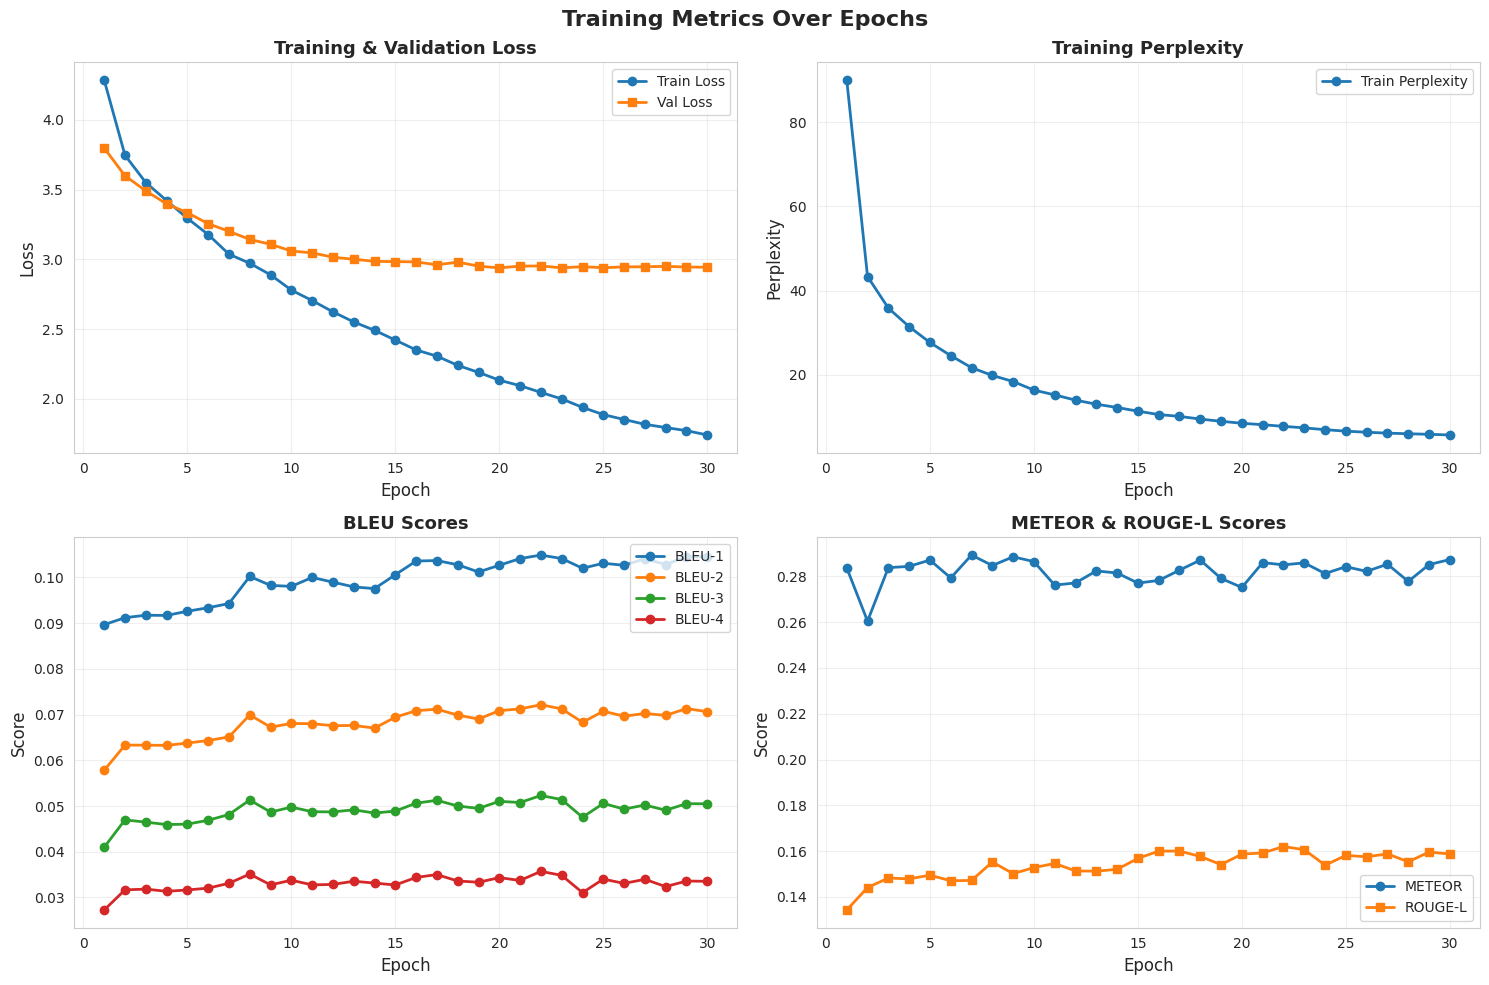

In [12]:
# Plot training metrics
print("\nGenerating visualizations...")

# 1. Training metrics (loss, perplexity, BLEU, METEOR, ROUGE)
fig1 = plot_training_metrics(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'training_metrics.png')
)
plt.show()

Learning rate plot saved to: /kaggle/working/outputs/first_frontal_impression_20260106_104534/visualizations/learning_rate.png


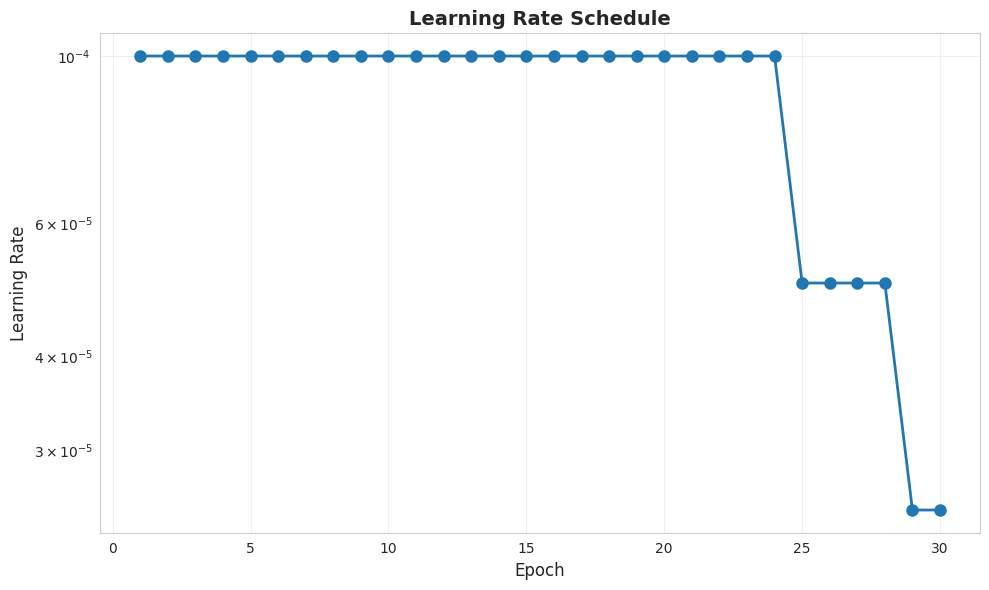

In [13]:
# 2. Learning rate schedule
fig2 = plot_learning_rate(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'learning_rate.png')
)
if fig2:
    plt.show()

Epoch time plot saved to: /kaggle/working/outputs/first_frontal_impression_20260106_104534/visualizations/epoch_time.png


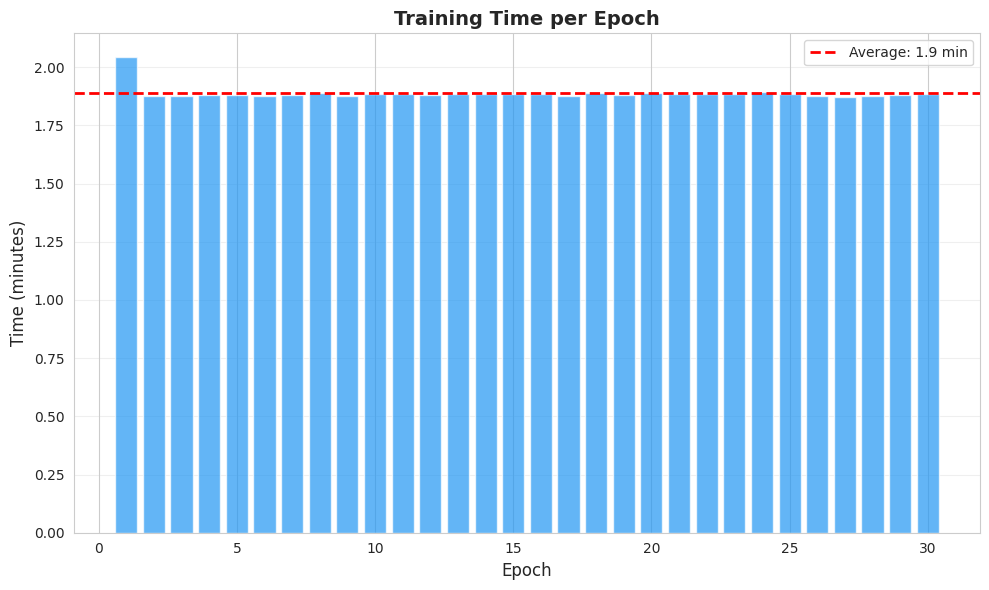

In [14]:
# 3. Epoch time
fig3 = plot_epoch_time(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'epoch_time.png')
)
if fig3:
    plt.show()

### Sample Predictions

Load and visualize sample predictions from the final epoch.

Loading samples from: epoch_030_samples.json
Loaded 10 sample predictions
Sample predictions plot saved to: /kaggle/working/outputs/first_frontal_impression_20260106_104534/visualizations/sample_predictions.png


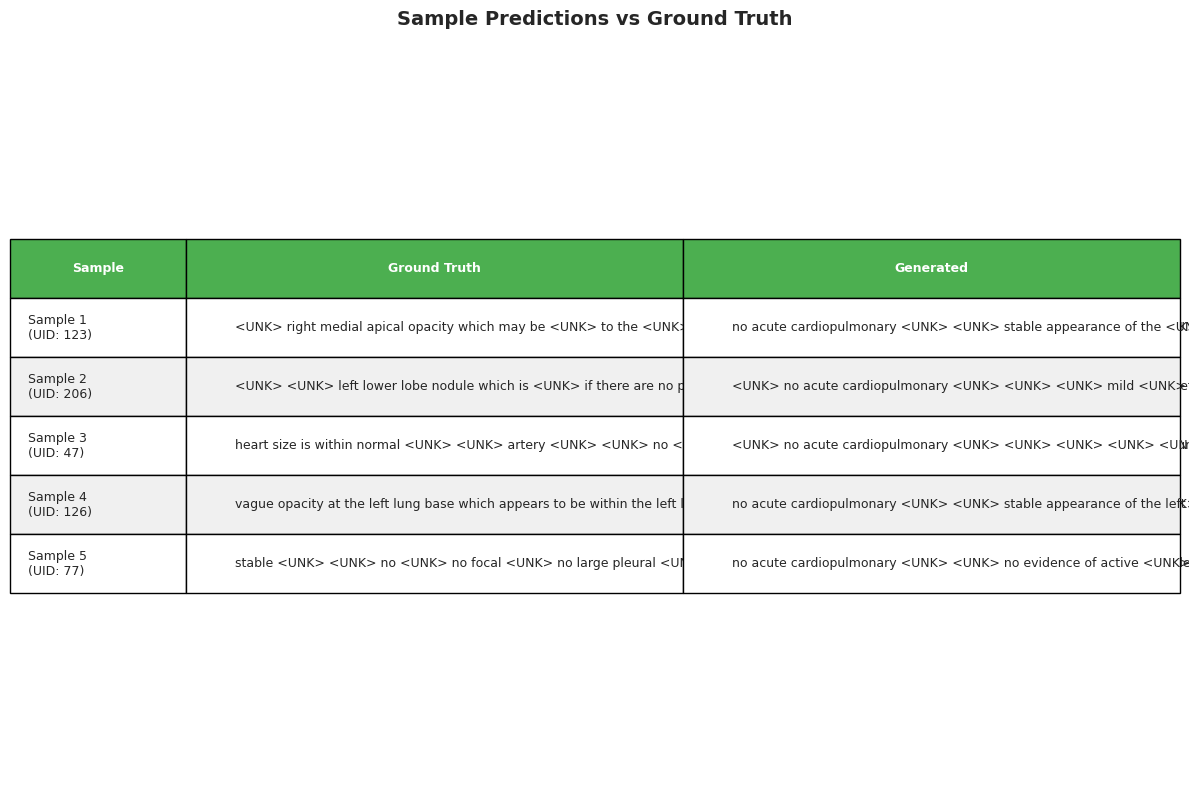


ALL SAMPLE PREDICTIONS

Sample 1 (UID: 123):
  Ground Truth: <UNK> right medial apical opacity which may be <UNK> to the <UNK> <UNK> upper lobe airspace disease or pulmonary nodule is not <UNK> <UNK> recommend <UNK> <UNK> chest and apical <UNK> view of the chest to further <UNK> findings and <UNK> were discussed <UNK> <UNK> in the <UNK>
  Generated:    no acute cardiopulmonary <UNK> <UNK> stable appearance of the <UNK> <UNK> deformity of the <UNK> <UNK> heart size is <UNK> <UNK> there is <UNK> no definite pleural effusion or <UNK> heart size is normal <UNK> no typical findings of pulmonary <UNK> heart size is normal and pulmonary <UNK> no <UNK>

Sample 2 (UID: 206):
  Ground Truth: <UNK> <UNK> left lower lobe nodule which is <UNK> if there are no prior films available for comparison <UNK> scan for further <UNK> pelvis and left <UNK> <UNK> <UNK> fracture left <UNK> <UNK> <UNK> no fracture the <UNK> <UNK> of the <UNK> left <UNK> <UNK> normal for <UNK>
  Generated:    <UNK> no acute card

In [15]:
# Load latest sample outputs
samples_dir = trainer.output_dir / 'sample_outputs'
sample_files = sorted(samples_dir.glob('epoch_*_samples.json'))

if sample_files:
    latest_samples_file = sample_files[-1]
    print(f"Loading samples from: {latest_samples_file.name}")
    
    with open(latest_samples_file, 'r') as f:
        samples = json.load(f)
    
    print(f"Loaded {len(samples)} sample predictions")
    
    # Plot sample predictions
    fig4 = plot_sample_predictions(
        samples=samples,
        max_samples=5,
        save_path=str(viz_dir / 'sample_predictions.png')
    )
    plt.show()
    
    # Print all samples
    print("\n" + "="*70)
    print("ALL SAMPLE PREDICTIONS")
    print("="*70)
    for i, sample in enumerate(samples, 1):
        print(f"\nSample {i} (UID: {sample['uid']}):")
        print(f"  Ground Truth: {sample['reference']}")
        print(f"  Generated:    {sample['generated']}")
else:
    print("No sample outputs found")

## 9. Final Metrics

Display best model performance and final evaluation metrics.

In [16]:
# Load training manifest
manifest_path = trainer.output_dir / 'training_manifest.json'

if manifest_path.exists():
    with open(manifest_path, 'r') as f:
        manifest = json.load(f)
    
    print("=" * 70)
    print("TRAINING SUMMARY")
    print("=" * 70)
    
    # Run info
    print(f"\nRun Information:")
    print(f"  Start time: {manifest['run_info']['start_time']}")
    if 'end_time' in manifest['run_info']:
        print(f"  End time: {manifest['run_info']['end_time']}")
        print(f"  Duration: {manifest['run_info']['duration_hours']:.2f} hours")
    
    # Hardware
    print(f"\nHardware:")
    print(f"  Device: {manifest['hardware']['device']}")
    if 'gpu_name' in manifest['hardware']:
        print(f"  GPU: {manifest['hardware']['gpu_name']}")
        print(f"  Memory: {manifest['hardware']['gpu_memory_gb']:.1f} GB")
    
    # Training summary
    if 'training_summary' in manifest:
        summary = manifest['training_summary']
        print(f"\nTraining Summary:")
        print(f"  Total epochs: {summary['total_epochs']}")
        print(f"  Total steps: {summary['total_steps']}")
        if 'best_epoch' in summary and summary['best_epoch']:
            print(f"  Best epoch: {summary['best_epoch']}")
            print(f"  Best {summary['best_metric']['name']}: {summary['best_metric']['value']:.4f}")
        
        if 'final_metrics' in summary and summary['final_metrics']:
            print(f"\n  Final Validation Metrics:")
            for metric, value in summary['final_metrics'].items():
                # Display metric with appropriate formatting
                metric_name = metric.replace('val_', '').replace('_', '-').upper()
                print(f"    {metric_name}: {value:.4f}")
else:
    print("Training manifest not found")

TRAINING SUMMARY

Run Information:
  Start time: 2026-01-06T10:45:34.589314
  End time: 2026-01-06T11:42:29.082116
  Duration: 0.95 hours

Hardware:
  Device: unknown
  GPU: unknown
  Memory: 0.0 GB

Training Summary:
  Total epochs: 30
  Total steps: 2790
  Best epoch: 20
  Best val_loss: 2.9397

  Final Validation Metrics:
    BLEU-1: 0.1045
    BLEU-2: 0.0706
    BLEU-3: 0.0505
    BLEU-4: 0.0335
    METEOR: 0.2874
    ROUGE-L: 0.1587
    LOSS: 2.9443


## 10. Load Best Model for Inference

Example of how to load the best model checkpoint for inference.

In [17]:
# Load best model checkpoint
from src.utils import CheckpointManager

checkpoint_manager = CheckpointManager(
    checkpoint_dir=str(trainer.output_dir / 'checkpoints'),
    max_checkpoints=5
)

best_checkpoint = checkpoint_manager.get_best_checkpoint()

if best_checkpoint:
    print(f"Loading best model from: {best_checkpoint}")
    
    # Create new model instance
    inference_model = EncoderDecoderModel(
        vocab_size=len(vocabulary),
        embedding_dim=config['model']['decoder']['embedding_dim'],
        encoder_feature_dim=config['model']['encoder']['output_feature_dim'],
        decoder_dim=config['model']['decoder']['hidden_dim'],
        attention_dim=config['model']['decoder']['attention']['attention_dim'],
        attention_type=config['model']['decoder']['attention']['type'],
        dropout=0.0,  # No dropout for inference
        encoder_architecture=config['model']['encoder']['architecture'],
        encoder_pretrained=False,  # Will load from checkpoint
        encoder_freeze=False
    ).to(device)
    
    # Load checkpoint
    checkpoint_info = checkpoint_manager.load_checkpoint(
        checkpoint_path=best_checkpoint,
        model=inference_model,
        device=device
    )
    
    inference_model.eval()
    
    print(f"✓ Best model loaded from epoch {checkpoint_info['epoch']}")
    print(f"  Metrics: {checkpoint_info['metrics']}")
    
    print("\nModel ready for inference!")
else:
    print("No best checkpoint found")

Loading best model from: /kaggle/working/outputs/first_frontal_impression_20260106_104534/checkpoints/best_model.pt
✓ Best model loaded from epoch 20
  Metrics: {'loss': 2.134471594646413, 'perplexity': 8.54951932353358, 'val_bleu_1': 0.10266304347826086, 'val_bleu_2': 0.07086297982206761, 'val_bleu_3': 0.05102448397937411, 'val_bleu_4': 0.034333990962713966, 'val_meteor': np.float64(0.2751598957344099), 'val_rouge_l': np.float64(0.15868556217550744), 'val_loss': 2.9396715561548867}

Model ready for inference!


In [18]:
# Example: Generate caption for random test image
if best_checkpoint:
    # Get random test sample
    test_sample_idx = np.random.randint(0, len(test_dataset))
    image, caption, caption_length, image_path, uid = test_dataset[test_sample_idx]
    
    print(f"Generating caption for test sample {test_sample_idx} (UID: {uid}):")
    print(f"  Image: {Path(image_path).name}")
    
    # Ground truth
    ground_truth = vocabulary.decode(caption.tolist())
    print(f"\nGround Truth: {ground_truth}")
    
    # Generate caption
    image_batch = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        generated_ids, scores = inference_model.generate_caption(
            image_batch,
            max_length=config['inference']['decoding']['max_length'],
            beam_size=config['inference']['decoding']['beam_size']
        )
    
    # Decode
    generated_caption = vocabulary.decode(generated_ids)
    print(f"Generated:    {generated_caption}")

Generating caption for test sample 129 (UID: 1592):
  Image: 1592_IM-0385-1001.dcm.png

Ground Truth: negative for acute cardiopulmonary <UNK>
Generated:    no acute cardiopulmonary <UNK> <UNK> <UNK> mild <UNK> <UNK> <UNK> <UNK> <UNK> in the <UNK> <UNK> <UNK> <UNK> of the <UNK> <UNK> <UNK> <UNK> of the <UNK> <UNK> <UNK> <UNK> <UNK> in the left upper <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> in the <UNK> <UNK> <UNK> <UNK> <UNK> in the
